In [1]:
# BigQuery connection
%load_ext google.cloud.bigquery

In [29]:
# imports
from google.cloud import bigquery
import pandas as pd
import numpy as np
from bq_helper import BigQueryHelper
import plotly
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

In [3]:
# API key verification for Google Cloud
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/Users/davidhofhuizen/Downloads/ambient-fuze-343609-fc7da1815720.json"

In [48]:
client = bigquery.Client()

In [6]:
# Test: Top 1000 bigquery balances
%%bigquery Top_1000_balances
WITH double_entry_book AS (
   -- debits
   SELECT array_to_string(inputs.addresses, ",") as address, inputs.type, -inputs.value as value
   FROM `bigquery-public-data.crypto_bitcoin.inputs` as inputs
   UNION ALL
   -- credits
   SELECT array_to_string(outputs.addresses, ",") as address, outputs.type, outputs.value as value
   FROM `bigquery-public-data.crypto_bitcoin.outputs` as outputs
)
SELECT address, type, sum(value) as balance
FROM double_entry_book
GROUP BY address, type
ORDER BY balance DESC
LIMIT 1000

Downloading: 100%|███████████████████████| 1000/1000 [00:01<00:00, 666.91rows/s]


In [7]:
Top_1000_balances

,address,type,balance
0,34xp4vRoCGJym3xR7yCVPFHoCNxv4Twseo,scripthash,25259722953995.000000000
1,bc1qgdjqv0av3q56jvd82tkdjpy7gdp9ut8tlqmgrpmv24...,witness_v0_scripthash,16800998565831.000000000
2,1P5ZEDWTKTFGxQjZphgWPQUpe554WKDfHQ,pubkeyhash,12642856918840.000000000
3,3LYJfcfHPXYJreMsASk2jkn69LWEYKzexb,scripthash,11660113654657.000000000
4,bc1qazcm763858nkj2dj986etajv6wquslv8uxwczt,witness_v0_keyhash,9464329910722.000000000
...,...,...,...
995,15HDbh92juxL9NRW4sm8wo3hmDoc32vWNM,pubkeyhash,186109810245.000000000
996,1CeD3b9j2KeSN3BgfcQCSpENCA99dg3qQp,pubkeyhash,186042495808.000000000
997,33wbHsWMaf2KSDAWr792oozC4miHLt1VZq,scripthash,185677858631.000000000
998,1N3WD1vDYUdUsn9BKpjoEHryZtgNW66xqD,pubkeyhash,185005233187.000000000


In [8]:
# Bigquery Helper
bitcoin = BigQueryHelper("bigquery-public-data","bitcoin_blockchain")

bitcoin.list_tables()

['blocks', 'transactions']

## Exploratory Data Analysis

In [37]:
%%bigquery gini_index
WITH double_entry_book AS (
    -- debits
    SELECT
     array_to_string(inputs.addresses, ",") as address
    , inputs.type
    , -inputs.value as value
    , block_timestamp
    FROM `bigquery-public-data.crypto_bitcoin.inputs` as inputs
 
    UNION ALL
 
    -- credits
    SELECT
     array_to_string(outputs.addresses, ",") as address
    , outputs.type
    , outputs.value as value
    , block_timestamp
    FROM `bigquery-public-data.crypto_bitcoin.outputs` as outputs
)
,double_entry_book_by_date as (
    select 
        date(block_timestamp) as date, 
        address, 
        sum(value / POWER(10,0)) as value
    from double_entry_book
    group by address, date
)
,daily_balances_with_gaps as (
    select 
        address, 
        date,
        sum(value) over (partition by address order by date) as balance,
        lead(date, 1, current_date()) over (partition by address order by date) as next_date
        from double_entry_book_by_date
)
,calendar as (
    select date from unnest(generate_date_array('2009-01-12', current_date())) as date
)
,daily_balances as (
    select address, calendar.date, balance
    from daily_balances_with_gaps
    join calendar on daily_balances_with_gaps.date <= calendar.date and calendar.date < daily_balances_with_gaps.next_date
)
,supply as (
    select
        date,
        sum(balance) as daily_supply
    from daily_balances
    group by date
)
,ranked_daily_balances as (
    select 
        daily_balances.date,
        balance,
        row_number() over (partition by daily_balances.date order by balance desc) as rank
    from daily_balances
    join supply on daily_balances.date = supply.date
    where safe_divide(balance, daily_supply) >= 0.0001
    ORDER BY safe_divide(balance, daily_supply) DESC
)

select 
    date, 
    -- (1 − 2B) https://en.wikipedia.org/wiki/Gini_coefficient
    1 - 2 * sum((balance * (rank - 1) + balance / 2)) / count(*) / sum(balance) as gini
from ranked_daily_balances
group by date
order by date asc

Downloading: 100%|██████████████████████| 4810/4810 [00:01<00:00, 2976.58rows/s]


In [39]:
#dataset for Gini index to compare with other econometric measures
gini_index['gini'] = gini_index['gini'].astype('float64')
gini_index['date'] = pd.to_datetime(gini_index['date'])

gini_index.info()

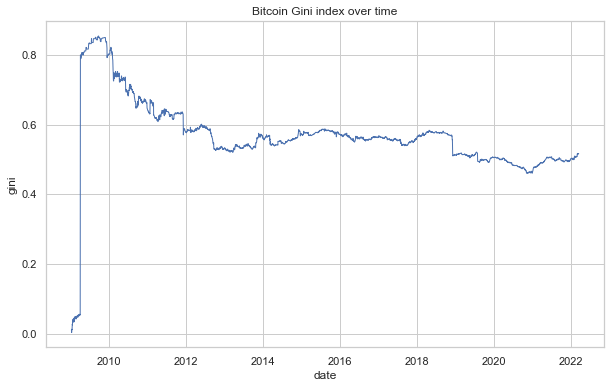

In [40]:
plt.figure(figsize = [10,6])
sns.lineplot(data=gini_index, x = 'date', y = 'gini', palette="tab10", linewidth=1)
plt.title("Bitcoin Gini index over time")
plt.show()

In [41]:
# export gini index dataset to avoid running query again 
gini_index.to_csv("Bitcoin_Gini-index.csv")

In [49]:
# transaction fees bitcoin data
query = """
SELECT 
    ROUND((input_value - output_value)/ size, 0) AS fees_per_byte,
    COUNT(*) AS txn_cnt
FROM
  `bigquery-public-data.crypto_bitcoin.transactions`
WHERE TRUE
  AND block_timestamp >= '2018-01-01' 
  AND is_coinbase IS FALSE
GROUP BY 1
"""
query_job = client.query(query)

iterator = query_job.result(timeout=30)
rows = list(iterator)

# Transform the rows into a nice pandas dataframe
zero_fee_btc = pd.DataFrame(data=[list(x.values()) for x in rows], columns=list(rows[0].keys()))

# Look at the first 10 headlines
zero_fee_btc.columns

Index(['fees_per_byte', 'txn_cnt'], dtype='object')

In [53]:
zero_fee_btc

,fees_per_byte,txn_cnt
0,2783,6
1,5285,1
2,6913,2
3,5918,1
4,3786,3
...,...,...
8154,12396,1
8155,4896,4
8156,8132,2
8157,8069,1


In [54]:
query = """
#standardSQL
SELECT
  o.day,
  COUNT(o.transaction_id) AS NoOfTrans
FROM (
  SELECT
    TIMESTAMP_MILLIS((timestamp - MOD(timestamp,
          86400000))) AS day,
    transaction_id
  FROM
    `bigquery-public-data.bitcoin_blockchain.transactions` ) AS o
GROUP BY
  day
ORDER BY
NoOfTrans desc
"""
query_job = client.query(query)

iterator = query_job.result(timeout=30)
rows = list(iterator)

# Transform the rows into a nice pandas dataframe
trans_day = pd.DataFrame(data=[list(x.values()) for x in rows], columns=list(rows[0].keys()))

# Look at the first 10 headlines
trans_day.head()

,day,NoOfTrans
0,2017-12-14 00:00:00+00:00,490644
1,2017-12-06 00:00:00+00:00,443587
2,2018-01-04 00:00:00+00:00,425008
3,2017-12-13 00:00:00+00:00,424579
4,2017-12-01 00:00:00+00:00,412908
